In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from spectpsftoolbox.simind_io import get_projections, get_source_detector_distances
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import dill
import pytomography
torch.manual_seed(0)
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Load Ac225 PSF data

In [2]:
E = 440
ds = [1,5,10,15,20,25,30,35,40,45,50,55]
headerpaths = [f'/home/gpuvmadm/spect_psf_fitting/datalarger/{E}kev_r{d}_tot_w1.h00' for d in ds]
psf_true = get_projections(headerpaths).to(device)[:,1:,1:]
respaths = [f'/home/gpuvmadm/spect_psf_fitting/datalarger/{E}kev_r{d}.res' for d in ds]
distances = get_source_detector_distances(respaths).to(device)
Nx0 = 255
dx0 = 0.24
x_eval = y_eval = torch.arange(-(Nx0-1)/2, (Nx0+1)/2, 1).to(device) * dx0
xv, yv = torch.meshgrid(x_eval, y_eval, indexing='xy')
input = torch.zeros(len(distances), Nx0, Nx0, device=device)
input[:,127,127] = 1 # line along center

with open(f'/home/gpuvmadm/PointSpreadFunctionFitter/notebook_testing/psf_operator_1D.pkl', 'rb') as f:
    psf_operator = dill.load(f)
psf_operator.set_device(pytomography.device)
psf_pred = psf_operator(input, xv,yv,distances)

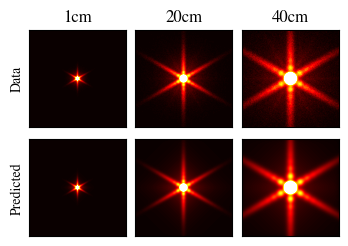

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(4,3), gridspec_kw={'hspace':-0.1, 'wspace':0.1})
for i in range(3):
    vmax = psf_pred[4*i].cpu().detach().numpy().max()/20
    plt.sca(ax[1,i])
    plt.imshow(psf_pred[4*i].cpu().detach().numpy(), cmap='hot', vmax=vmax)
    plt.sca(ax[0,i])
    plt.imshow(psf_true[4*i].cpu().numpy(), cmap='hot', vmax=vmax)
    ax[0,i].set_title('{:.0f}cm'.format(distances[4*i].item()))

[a.set_xticks([]) for a in ax.ravel()]
[a.set_yticks([]) for a in ax.ravel()]
ax[1,0].set_ylabel('Predicted')
ax[0,0].set_ylabel('Data')
#fig.tight_layout()
plt.savefig('/home/gpuvmadm/PointSpreadFunctionFitter/paper/figures/ac_kernels.png', dpi=300, bbox_inches='tight')

In [4]:
ac_bad = torch.load('/disk1/psf_data/toolbox_plots_data/ac225_reconbad.pt')
ac_1Dfit = torch.load('/disk1/psf_data/toolbox_plots_data/ac225_recon1Dfit.pt')
ac_2D = torch.load('/disk1/psf_data/toolbox_plots_data/ac225_recon2D.pt')
recons = [ac_bad, ac_1Dfit, ac_2D]
labels = ['GC Only',  'GC+SPC+SSC [2D MC]', 'GC+SPC+SSC [1D-R]']

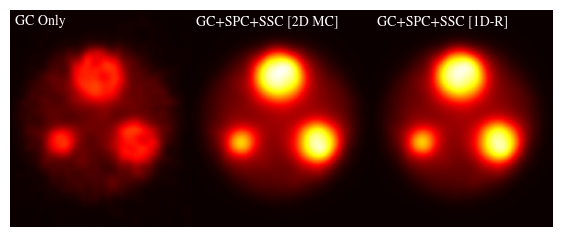

In [5]:
fig, ax = plt.subplots(1,3,figsize=(7,3), gridspec_kw={'hspace':-0.05, 'wspace':0.0})
vmax = recons[2].max()
for i in range(3):
    plt.sca(ax[i])
    plt.imshow(recons[i][:,:,64].cpu().T, cmap='hot', interpolation='gaussian', vmax=vmax)
    plt.xlim(64-25, 64+25)
    plt.ylim(64-30, 64+30)
    plt.axis('off')
    plt.text(0.03,0.93,labels[i],color='white', transform=ax[i].transAxes)
plt.savefig('/home/gpuvmadm/PointSpreadFunctionFitter/paper/figures/ac225recons.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_20914/772137018.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.plot(x, recons[0][:,IDX_y,IDX_z].cpu().T, color='k', label=labels[0])


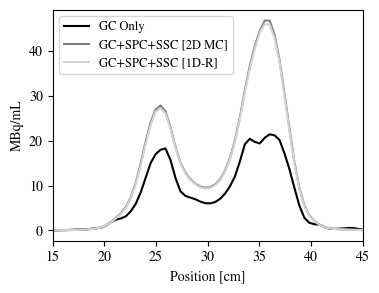

In [6]:
IDX_y = 55
IDX_z = 64
x = torch.arange(128)*0.48
plt.figure(figsize=(4,3))
plt.plot(x, recons[0][:,IDX_y,IDX_z].cpu().T, color='k', label=labels[0])
plt.plot(x, recons[1][:,IDX_y,IDX_z].cpu().T, color='grey', label=labels[1])
plt.plot(x, recons[2][:,IDX_y,IDX_z].cpu().T, color='lightgrey', label=labels[2])
plt.legend(fontsize=9)
plt.xlim(15,45)
plt.xlabel('Position [cm]')
plt.ylabel('MBq/mL')
plt.savefig('/home/gpuvmadm/PointSpreadFunctionFitter/paper/figures/ac225recons_profile.png', dpi=300, bbox_inches='tight')

Lu177 PSF

In [7]:
headerpaths = np.array([f'/disk1/psf_data/208keV_LE_PSF/point_position{i}_tot_w1.h00' for i in range(538,1638)])
respaths = np.array([f'/disk1/psf_data/208keV_LE_PSF/point_position{i}.res' for i in range(538,1638)])
distances = get_source_detector_distances(respaths).to(device)
projectionss_data = get_projections(headerpaths).to(device)[:,1:,1:]

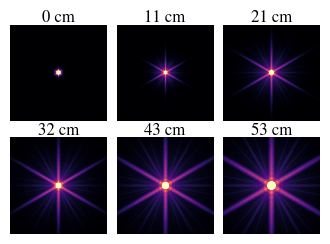

In [8]:
fig, ax = plt.subplots(2,3, figsize=(4,3), gridspec_kw={'hspace':-0.05, 'wspace':0.1})
for i, IDX in enumerate([0,200,400,600,800,1000]):
    plt.sca(ax.ravel()[i])
    plt.imshow(projectionss_data[IDX].cpu().numpy(), cmap='magma', vmax=projectionss_data[IDX].cpu().numpy().max()/10)
    plt.title(f'{distances[IDX].item():.0f} cm', y=0.95)
    plt.axis('off')
plt.savefig('/home/gpuvmadm/PointSpreadFunctionFitter/paper/figures/lu177kernels.png', dpi=300, bbox_inches='tight')

Lu177 recons

In [9]:
calib_le = 1 / (66.1719 * 15) / 0.48**3 # CPS / MBq times time
calib_me = 1 / (11.9833 * 15) / 0.48**3

In [10]:
lu177_me = torch.load('/disk1/psf_data/toolbox_plots_data/lu177_me_4it8ss.pt') * calib_me
lu177_le_bad = torch.load('/disk1/psf_data/toolbox_plots_data/lu177_le_badPSF_40it8ss.pt') * calib_le
lu177_le_good = torch.load('/disk1/psf_data/toolbox_plots_data/lu177_le_goodPSF_40it8ss.pt') * calib_le
recons = [lu177_le_bad, lu177_me, lu177_le_good]
sums = [r.sum().item() for r in recons]
labels = ['Low Energy [GC]', 'Medium Energy [GC]', 'Low Energy [GC+SPC+SSC]', ]

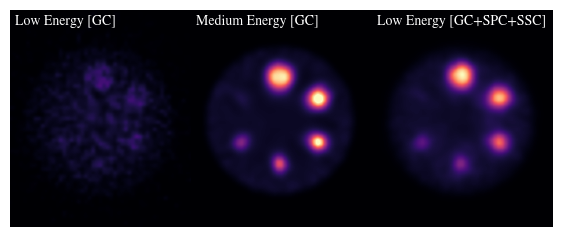

In [11]:
fig, ax = plt.subplots(1,3,figsize=(7,3), gridspec_kw={'hspace':-0.05, 'wspace':0.0})
vmax = recons[1].max() / 1.2
for i in range(3):
    plt.sca(ax[i])
    plt.imshow(recons[i][:,:,64].cpu().T, cmap='magma', interpolation='gaussian', vmax=vmax)
    plt.xlim(64-25, 64+25)
    plt.ylim(64-30, 64+30)
    plt.axis('off')
    plt.text(0.03,0.93,labels[i],color='white', transform=ax[i].transAxes)
plt.savefig('/home/gpuvmadm/PointSpreadFunctionFitter/paper/figures/lu177recons.png', dpi=300, bbox_inches='tight')

In [12]:
x = torch.arange(128)*0.48

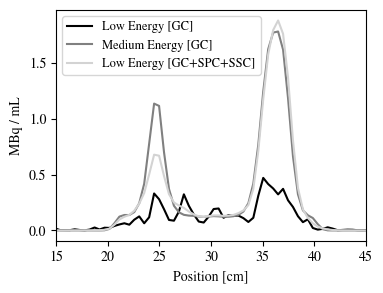

In [13]:
IDX_x = 64
IDX_z = 64
plt.figure(figsize=(4,3))
plt.plot(x, recons[0][IDX_x,:,IDX_z].cpu().T, color='k', label=labels[0])
plt.plot(x, recons[1][IDX_x,:,IDX_z].cpu().T, color='grey', label=labels[1])
plt.plot(x, recons[2][IDX_x,:,IDX_z].cpu().T, color='lightgrey', label=labels[2])
plt.legend(fontsize=9)
plt.xlim(15,45)
plt.xlabel('Position [cm]')
plt.ylabel('MBq / mL')
plt.savefig('/home/gpuvmadm/PointSpreadFunctionFitter/paper/figures/lu177recons_profile.png', dpi=300, bbox_inches='tight')